# Libraries

In [ ]:
pip install grad-cam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Imports

In [ ]:
# imports

import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms

from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt

import torch.nn as nn

import time

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.transforms.Grayscale(),
    torchvision.transforms.RandomRotation([-10,10])
])

In [ ]:
dataset=torchvision.datasets.MNIST(root='.\data', download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 89585449.47it/s]


Extracting .\data/MNIST/raw/train-images-idx3-ubyte.gz to .\data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18693779.91it/s]


Extracting .\data/MNIST/raw/train-labels-idx1-ubyte.gz to .\data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32682406.69it/s]


Extracting .\data/MNIST/raw/t10k-images-idx3-ubyte.gz to .\data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14941591.19it/s]

Extracting .\data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .\data/MNIST/raw



# Data Sample Overview

In [ ]:
mapping = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}
numbers=list(mapping.values())

Dataset contains  60000  samples.


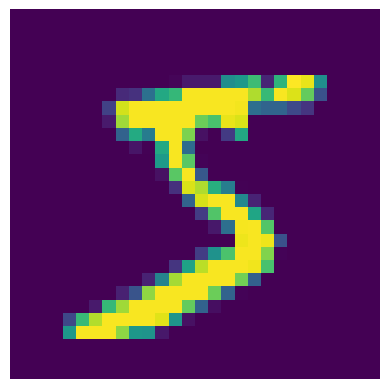

In [ ]:
event, label = dataset[0]

# Dataset size
print("Dataset contains ", len(dataset), " samples.")
plt.imshow(event)
plt.axis(False)
plt.show()

In [ ]:
class ANN(nn.Module):
    def __init__(self):
      super(ANN, self).__init__()
      self.features = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(24, 64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
      
      self.classifier = nn.Sequential(
            nn.Linear(1600, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
from torchvision.datasets import mnist
train_data = mnist.MNIST('mnist', train=True, transform=transform, download=True)
test_data = mnist.MNIST('mnist', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 119269253.43it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20878265.05it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31720198.31it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12599556.06it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



# Neural Network and Training

In [ ]:
# Initialise model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
model = ANN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [ ]:
accuracies=[]
losses=[]
start=time.time()
num_iters = 20
epoches=5
for epoch in range(epoches):
  model.train()
  for i, (images, labels) in enumerate(iter(train_loader)):
    images=images.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Evaluate model using test_set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    losses.append(loss)
    print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss:.2f}")
    print(f"Accuracy: {accuracy:.2f}%\n")
    if i == num_iters:
      break
end=time.time()
print(f'Total training time{end-start} seconds.')

Epoch 0, Iteration 0 
Train Loss: 2.30
Accuracy: 21.84%

Epoch 0, Iteration 1 
Train Loss: 2.28
Accuracy: 44.01%

Epoch 0, Iteration 2 
Train Loss: 2.23
Accuracy: 44.55%

Epoch 0, Iteration 3 
Train Loss: 2.16
Accuracy: 41.68%

Epoch 0, Iteration 4 
Train Loss: 2.13
Accuracy: 57.49%

Epoch 0, Iteration 5 
Train Loss: 2.00
Accuracy: 66.82%

Epoch 0, Iteration 6 
Train Loss: 1.84
Accuracy: 65.30%

Epoch 0, Iteration 7 
Train Loss: 1.68
Accuracy: 74.66%

Epoch 0, Iteration 8 
Train Loss: 1.49
Accuracy: 66.55%

Epoch 0, Iteration 9 
Train Loss: 1.30
Accuracy: 72.02%

Epoch 0, Iteration 10 
Train Loss: 1.07
Accuracy: 75.56%

Epoch 0, Iteration 11 
Train Loss: 0.97
Accuracy: 69.73%

Epoch 0, Iteration 12 
Train Loss: 1.09
Accuracy: 77.87%

Epoch 0, Iteration 13 
Train Loss: 0.82
Accuracy: 77.24%

Epoch 0, Iteration 14 
Train Loss: 0.80
Accuracy: 78.81%

Epoch 0, Iteration 15 
Train Loss: 0.79
Accuracy: 81.12%

Epoch 0, Iteration 16 
Train Loss: 0.60
Accuracy: 81.46%

Epoch 0, Iteration 17 
T

In [ ]:
torch.save(model.state_dict(), 'ann.pth')

# Results

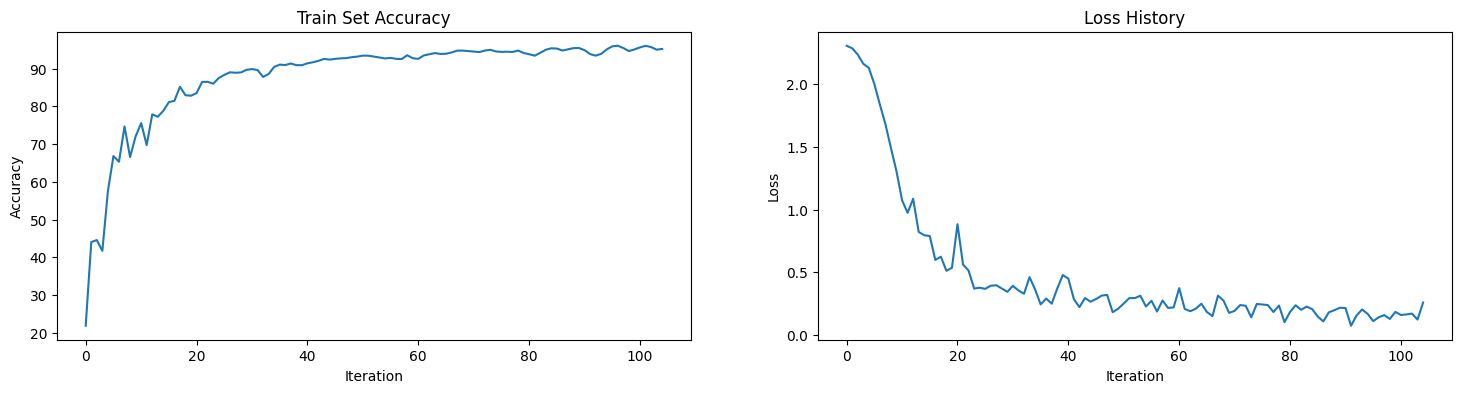

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,4))

# Plot Train Accuracy
axes[0].plot(accuracies)
axes[0].set_title("Train Set Accuracy")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Accuracy")

losses = [loss.cpu().detach().numpy() for loss in losses]
# Plot Training Loss
axes[1].plot(losses)
axes[1].set_title("Loss History")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.show()

In [ ]:
# Evaluate Test Set Accuracy
correct = 0
total = 0

true_labels = []
predictions = []

for images, labels in test_loader:
  images = images.to(device)
  labels = labels.to(device)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  predictions.append(predicted)
  true_labels.append(labels)
print("Test Set Accuracy: ", (correct/total) * 100, "%")

Test Set Accuracy:  95.16 %


In [ ]:
pred_list=[]
for prediction in predictions:
    pred_list.append(prediction.tolist())

true_list=[]
for test in true_labels:
    true_list.append(test.tolist())

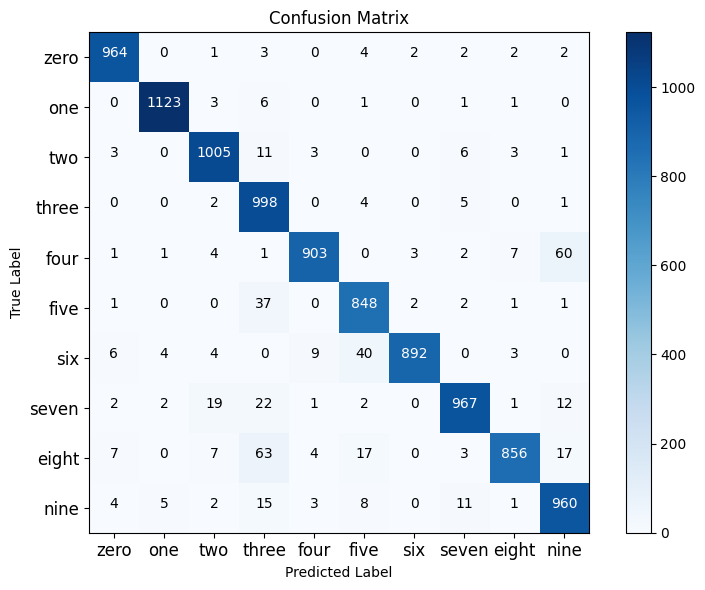

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

pred_array = np.array([label for sublist in pred_list for label in sublist])
true_array = np.array([label for sublist in true_list for label in sublist])

cm = confusion_matrix(true_array, pred_array)
plt.figure(figsize=(8, 6))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar()

classes = numbers
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
for i in model.features:
  print(i)

Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


# Visualizing Weight Distribution

The focus of Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)).


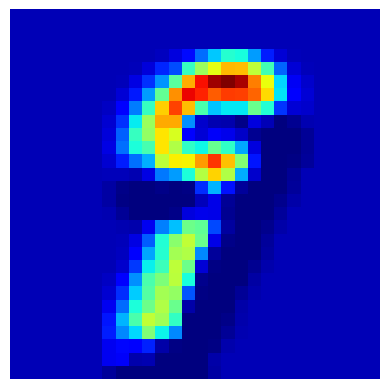

The focus of ReLU().


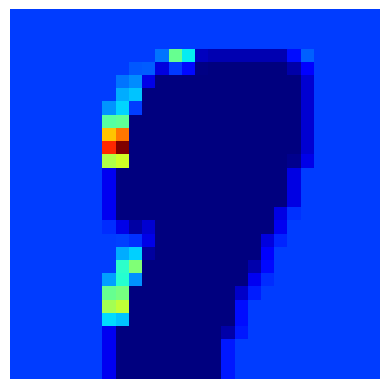

The focus of MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False).


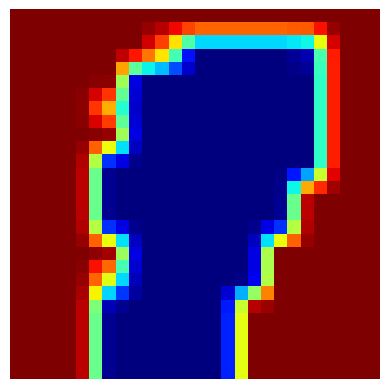

The focus of Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)).


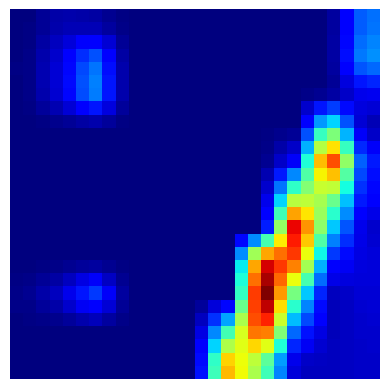

The focus of ReLU().


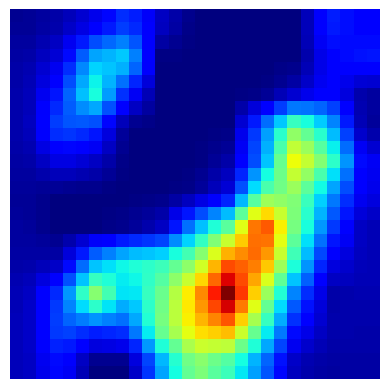

The focus of MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False).


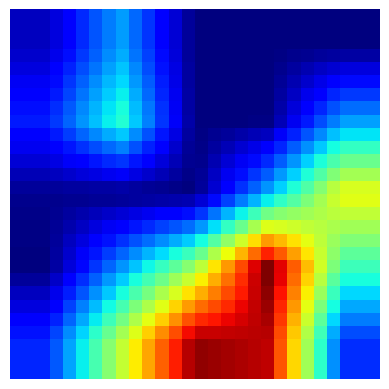

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_cam_on_mnist(model, cam):
    img = cam[0]
    img = np.uint8(255 * img)
    plt.imshow(img, cmap='jet')
    plt.axis('off')
    plt.show()

images, labels = next(iter(test_loader))
for i in model.features:
  target_layers = [i]
  cam = GradCAM(model=model, target_layers=target_layers)
  grayscale_cam = cam(input_tensor=images, targets=None)
  print(f'The focus of {i}.')
  visualize_cam_on_mnist(model, grayscale_cam)

In [ ]:
grayscale_cam.dtype

dtype('float32')